In [175]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import scipy.stats as stats
from scipy.spatial import distance
from scipy.stats import chi2
from matplotlib import rc
from sklearn.neighbors import KernelDensity
import matplotlib

import seaborn as sns

from historymatch import sample

np.random.seed(2)

rc('font',**{'family':'serif'})
rc('text', usetex=True)

In [176]:
SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 26


plt.rc('font', size=26)          # controls default text sizes
plt.rc('axes', titlesize=28)     # fontsize of the axes title
plt.rc('axes', labelsize=36)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=26)    # legend fontsize
plt.rc('figure', titlesize=26)  # fontsize of the figure title

In [177]:
def uniform_ellipsoid_sample(ndim, Nsamples, Ntraining, nonimplausible_samples, inactive=False, parameter_bounds=None):

    '''
    Generate well-spaced samples distributed according to a multivariate normal distribution.
    Args
    ---
    ndim : int
        Number of dimensions
    Ntraining : int
        Number of training points to generate.
    Nsamples : int
        Total number of samples to generate.
    mean : ndarray, shape (ndim,)
        Mean of normal distribution.
    covariance : ndarray, shape (ndim, ndim)
        Covariance matrix of distribution.
    Returns
    -------
    parameter_train : ndarray, shape (Ntraining, ndim)
        Input parameters used within simulator to generate outputs for emulator training.
    parameter_samples : ndarray, shape (Nsamples, ndim)
        Well spaced samples in parameter space.
    
    '''

    # compute mean and covariance of non-implausible samples
    covariance = np.cov(nonimplausible_samples.T)

    mean = np.mean(nonimplausible_samples, axis=0)

    # generate sample points
    uniform_train = lhs(ndim, samples=Ntraining, criterion='center')
    uniform_samples = lhs(ndim, samples=Nsamples, criterion='center')

    if inactive == True:
        ndim -= 1

    # normally distribute sample points
    normal_train = np.zeros_like(uniform_train)
    normal_samples = np.zeros_like(uniform_samples)
    for i in range(ndim):
        normal_train[:,i] = norm(loc=0, scale=1).ppf(uniform_train[:,i])
        normal_samples[:,i] = norm(loc=0, scale=1).ppf(uniform_samples[:,i])
    
    # compute norm and divide by
    train_norm = np.linalg.norm(normal_train[:,:ndim], axis=1)
    sample_norm = np.linalg.norm(normal_samples[:,:ndim], axis=1)

    uniform_ell_train = np.zeros_like(normal_train[:,:ndim])
    uniform_ell_samples = np.zeros_like(normal_samples[:,:ndim])
    for i in range(ndim):
        uniform_ell_train[:,i] = normal_train[:,i]/train_norm
        uniform_ell_samples[:,i] = normal_samples[:,i]/sample_norm

    # radially distribute samples
    r_train = lhs(ndim, samples=Ntraining, criterion='center')
    #r_samp = lhs(ndim, samples=Nsamples, criterion='center')
    r_samp = np.zeros((Nsamples,ndim))
    
    for i in range(ndim):
        r_samp[:,i] = np.linspace(0,1,Nsamples)
        #r_samp[:,i] = np.ones(Nsamples)

    uniform_ell_train *= r_train**(1.0/ndim)
    uniform_ell_samples *= r_samp**(1.0/ndim)

    # Add pertubation to covariance
    epsilon = 1e-9
    K = covariance + epsilon*np.identity(ndim)

    # Compute the Cholesky decomposition
    L = np.linalg.cholesky(K)

    # correlate samples
    ell_train = np.dot(L, uniform_ell_train.T)
    ell_samples = np.dot(L, uniform_ell_samples.T)

    # recentre and resize to 95% C.I.
    chisq = [3.841,5.991,7.815,9.488,11.070,12.592,14.067,15.507]    # 95% C.I. chisq values
    input_train = mean.reshape(ndim, 1) + np.sqrt(chisq[ndim-1])*ell_train
    parameter_samples = mean.reshape(ndim, 1) + np.sqrt(chisq[ndim-1])*ell_samples
    
    if inactive == True:
        uniform_train[:,-1] = uniform_train[:,-1]*(parameter_bounds[-1,1]-parameter_bounds[-1,0]) + parameter_bounds[-1,0]
        uniform_samples[:,-1] = uniform_samples[:,-1]*(parameter_bounds[-1,1]-parameter_bounds[-1,0]) + parameter_bounds[-1,0]
        input_train_inac = np.concatenate((input_train.T, uniform_train[:,-1].reshape(-1,1)),axis=1)
        parameter_samples_inac = np.concatenate((parameter_samples.T, uniform_samples[:,-1].reshape(-1,1)),axis=1)
        return input_train_inac, parameter_samples_inac

    return input_train.T, parameter_samples.T

In [178]:
def random_ellipsoid_sample(ndim, Nsamples, Ntraining, nonimplausible_samples, inactive=False, parameter_bounds=None, r_rand=False):

    '''
    Generate well-spaced samples distributed according to a multivariate normal distribution.
    Args
    ---
    ndim : int
        Number of dimensions
    Ntraining : int
        Number of training points to generate.
    Nsamples : int
        Total number of samples to generate.
    mean : ndarray, shape (ndim,)
        Mean of normal distribution.
    covariance : ndarray, shape (ndim, ndim)
        Covariance matrix of distribution.
    Returns
    -------
    parameter_train : ndarray, shape (Ntraining, ndim)
        Input parameters used within simulator to generate outputs for emulator training.
    parameter_samples : ndarray, shape (Nsamples, ndim)
        Well spaced samples in parameter space.
    
    '''

    # compute mean and covariance of non-implausible samples
    covariance = np.cov(nonimplausible_samples.T)

    mean = np.mean(nonimplausible_samples, axis=0)

    # generate sample points
    normal_train = np.random.multivariate_normal(mean, covariance, Ntraining)
    normal_samples = np.random.multivariate_normal(mean, covariance, Nsamples)
    
    # generate sample points
    #uniform_train = lhs(ndim, samples=Ntraining, criterion='center')
    #uniform_samples = lhs(ndim, samples=Nsamples, criterion='center')
    
    # compute norm and divide by
    train_norm = np.linalg.norm(normal_train[:,:ndim], axis=1)
    sample_norm = np.linalg.norm(normal_samples[:,:ndim], axis=1)

    uniform_ell_train = np.zeros_like(normal_train[:,:ndim])
    uniform_ell_samples = np.zeros_like(normal_samples[:,:ndim])
    for i in range(ndim):
        uniform_ell_train[:,i] = normal_train[:,i]/train_norm
        uniform_ell_samples[:,i] = normal_samples[:,i]/sample_norm

    # radially distribute samples
    
    if r_rand == True:
        r_train = np.random.uniform(low=0.0, high=1.0, size=(Ntraining,ndim))
        r_samp = np.random.uniform(low=0.0, high=1.0, size=(Nsamples,ndim))
    
    else:
        # radially distribute samples
        r_train = lhs(ndim, samples=Ntraining, criterion='center')
        r_samp = np.zeros((Nsamples,ndim))

        for i in range(ndim):
            r_samp[:,i] = np.linspace(0,1,Nsamples)
            #r_samp[:,i] = np.ones(Nsamples)
    
    uniform_ell_train *= r_train**(1.0/ndim)
    uniform_ell_samples *= r_samp**(1.0/ndim)

    # Add pertubation to covariance
    epsilon = 1e-9
    K = covariance + epsilon*np.identity(ndim)

    # Compute the Cholesky decomposition
    L = np.linalg.cholesky(K)

    # correlate samples
    ell_train = np.dot(L, uniform_ell_train.T)
    ell_samples = np.dot(L, uniform_ell_samples.T)

    # recentre and resize to 95% C.I.
    chisq = [3.841,5.991,7.815,9.488,11.070,12.592,14.067,15.507]    # 95% C.I. chisq values
    input_train = mean.reshape(ndim, 1) + np.sqrt(chisq[ndim-1])*ell_train
    parameter_samples = mean.reshape(ndim, 1) + np.sqrt(chisq[ndim-1])*ell_samples
    
    if inactive == True:
        uniform_train[:,-1] = uniform_train[:,-1]*(parameter_bounds[-1,1]-parameter_bounds[-1,0]) + parameter_bounds[-1,0]
        uniform_samples[:,-1] = uniform_samples[:,-1]*(parameter_bounds[-1,1]-parameter_bounds[-1,0]) + parameter_bounds[-1,0]
        input_train_inac = np.concatenate((input_train.T, uniform_train[:,-1].reshape(-1,1)),axis=1)
        parameter_samples_inac = np.concatenate((parameter_samples.T, uniform_samples[:,-1].reshape(-1,1)),axis=1)
        return input_train_inac, parameter_samples_inac

    return input_train.T, parameter_samples.T

In [179]:
def random_gaussian_sample(ndim, Nsamples, Ntraining, nonimplausible_samples, inactive=False, parameter_bounds=None):

    '''
    Generate well-spaced samples distributed according to a multivariate normal distribution.
    Args
    ---
    ndim : int
        Number of dimensions
    Ntraining : int
        Number of training points to generate.
    Nsamples : int
        Total number of samples to generate.
    mean : ndarray, shape (ndim,)
        Mean of normal distribution.
    covariance : ndarray, shape (ndim, ndim)
        Covariance matrix of distribution.
    Returns
    -------
    parameter_train : ndarray, shape (Ntraining, ndim)
        Input parameters used within simulator to generate outputs for emulator training.
    parameter_samples : ndarray, shape (Nsamples, ndim)
        Well spaced samples in parameter space.
    
    '''

    # compute mean and covariance of non-implausible samples
    covariance = np.cov(nonimplausible_samples.T)
    mean = np.mean(nonimplausible_samples, axis=0)

    # generate sample points
    input_train = np.random.multivariate_normal(mean, covariance, Ntraining)
    parameter_samples = np.random.multivariate_normal(mean, covariance, Nsamples)

    return input_train, parameter_samples

In [180]:
nonimplausible = np.random.multivariate_normal([0,0], [[1,-0.7],[-0.7,1]], 100)

nonimplausible2 = np.random.multivariate_normal([0,0,0,0], [[1,-0.65, 0.3, 0.14],[-0.65,1, 0, 0], [0.3,0, 1, 0.5], [0.14, 0, 0.5, 1]], 100)

nonimplausible3 = np.random.multivariate_normal([0,0,0], [[1,-0.65, 0.3],[-0.65,1, 0], [0.3,0, 1]], 100)

In [181]:
train, ellipsoid_lhs_2D = uniform_ellipsoid_sample(2, 1000, 10, nonimplausible, inactive=False, parameter_bounds=None)

train, ellipsoid_rand_samples_2D = random_ellipsoid_sample(2, 1000, 10, nonimplausible, inactive=False, parameter_bounds=None, r_rand = False)

train, ellipsoid_rand_both_2D = random_ellipsoid_sample(2, 1000, 10, nonimplausible, inactive=False, parameter_bounds=None, r_rand = True)



train, gaussian_lhs = sample.gaussian_sample(2, 1000, 10, nonimplausible, inactive=False, parameter_bounds=None)

train, gaussian_rand = random_gaussian_sample(2, 1000, 10, nonimplausible, inactive=False, parameter_bounds=None)





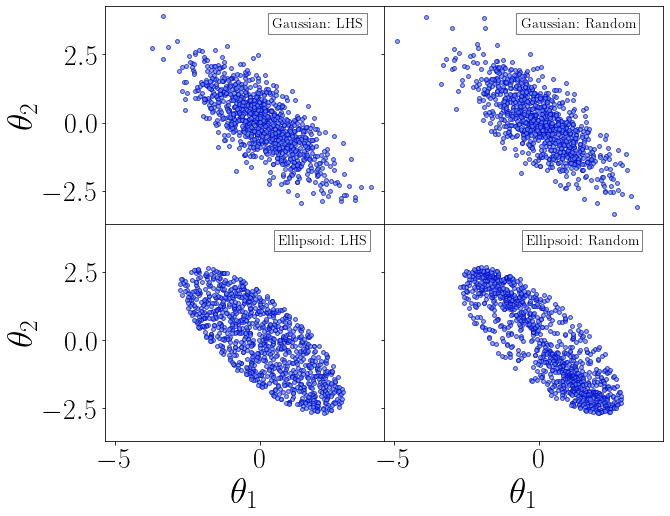

In [182]:
props = dict(boxstyle='square', facecolor='None', alpha=0.5)


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8),sharex=True,sharey=True)


ax1.scatter(gaussian_lhs[:,0], gaussian_lhs[:,1], s=15, c='cornflowerblue', ec='mediumblue', lw=1, alpha=0.7)

ax1.text(0.6, 0.95, 'Gaussian: LHS', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2.scatter(gaussian_rand[:,0], gaussian_rand[:,1], s=15, c='cornflowerblue', ec='mediumblue', lw=1, alpha=0.7)

ax2.text(0.49, 0.95, 'Gaussian: Random', transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


ax3.scatter(ellipsoid_lhs_2D[:,0], ellipsoid_lhs_2D[:,1], s=15, c='cornflowerblue', ec='mediumblue', lw=1, alpha=0.7)

ax3.text(0.62, 0.95, 'Ellipsoid: LHS', transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax4.scatter(ellipsoid_rand_samples_2D[:,0], ellipsoid_rand_samples_2D[:,1], s=15, c='cornflowerblue', ec='mediumblue', lw=1, alpha=0.7)

ax4.text(0.51, 0.95, 'Ellipsoid: Random', transform=ax4.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax1.set_ylabel(r'$\theta_2$')
ax3.set_ylabel(r'$\theta_2$')

ax3.set_xlabel(r'$\theta_1$')
ax4.set_xlabel(r'$\theta_1$')

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('figures/sample_comparison.png', bbox_inches='tight', facecolor='white', transparent=False)

In [223]:
train, ellipsoid_lhs_4d = uniform_ellipsoid_sample(4, 1000000, 10, nonimplausible2, inactive=False, parameter_bounds=None)

train, ellipsoid_rand_samples_4d = random_ellipsoid_sample(4, 1000000, 10, nonimplausible2, inactive=False, parameter_bounds=None, r_rand = False)

train, ellipsoid_rand_both_4d = random_ellipsoid_sample(4, 1000000, 10, nonimplausible2, inactive=False, parameter_bounds=None, r_rand = True)

In [184]:
train, ellipsoid_lhs_3d = uniform_ellipsoid_sample(3, 100, 10, nonimplausible3, inactive=False, parameter_bounds=None)

train, ellipsoid_rand_samples_3d = random_ellipsoid_sample(3, 1000, 10, nonimplausible3, inactive=False, parameter_bounds=None, r_rand = False)

train, ellipsoid_rand_both_3d = random_ellipsoid_sample(3, 100, 10, nonimplausible3, inactive=False, parameter_bounds=None, r_rand = True)

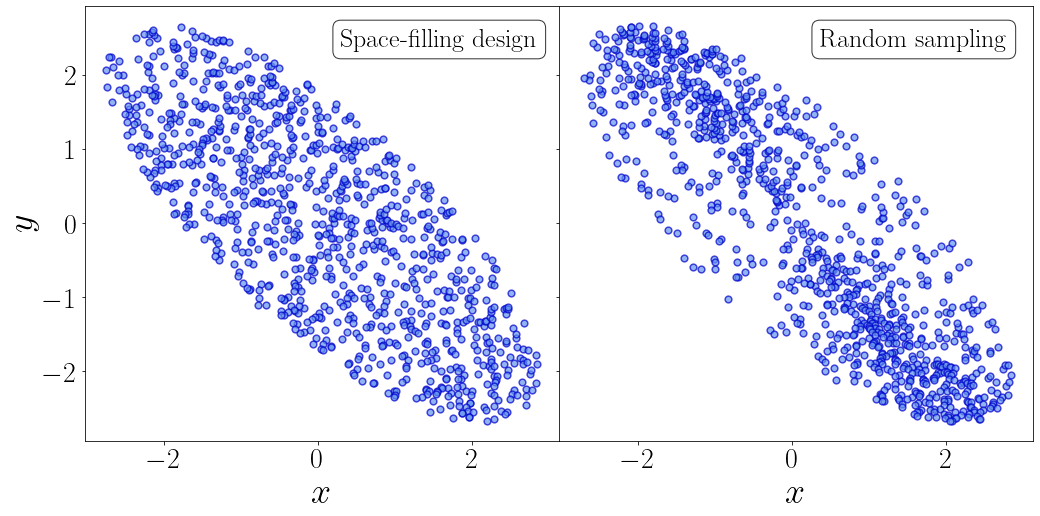

In [185]:
#props = dict(boxstyle='square', facecolor=None, alpha=1)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,8),sharex=True,sharey=True)

ax1.scatter(ellipsoid_lhs_2D[:,0], ellipsoid_lhs_2D[:,1], s=45, c='cornflowerblue', ec='mediumblue', lw=1.5, alpha=0.7, zorder=5)

ax1.text(0.54, 0.95, 'Space-filling design', transform=ax1.transAxes, fontsize=26,
        verticalalignment='top', bbox=props)

#ax1.text(0.9, 0.97, 'Ellipsoid: LHS', transform=ax3.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)

ax2.scatter(ellipsoid_rand_samples_2D[:,0], ellipsoid_rand_samples_2D[:,1], s=45, c='cornflowerblue', ec='mediumblue', lw=1.5, alpha=0.7)

ax2.text(0.55, 0.95, 'Random sampling', transform=ax2.transAxes, fontsize=26,
        verticalalignment='top', bbox=props)


#ax2.scatter(ellipsoid_rand_samples_2D[:,0], ellipsoid_rand_samples_2D[:,1], s=15, c='cornflowerblue', ec='mediumblue', lw=1, alpha=0.7)

#ax2.text(0.35, 0.95, 'Random samples, uniform r', transform=ax3.transAxes, fontsize=14,
        #verticalalignment='top', bbox=props)



ax1.set_ylabel(r'$y$')
#ax3.set_ylabel(r'$\theta_2$')

ax2.set_xlabel(r'$x$')
ax1.set_xlabel(r'$x$')

plt.subplots_adjust(wspace=0, hspace=0)


plt.savefig('figures/ellipsoid_comparison.pdf', bbox_inches='tight', facecolor='white', transparent=False)

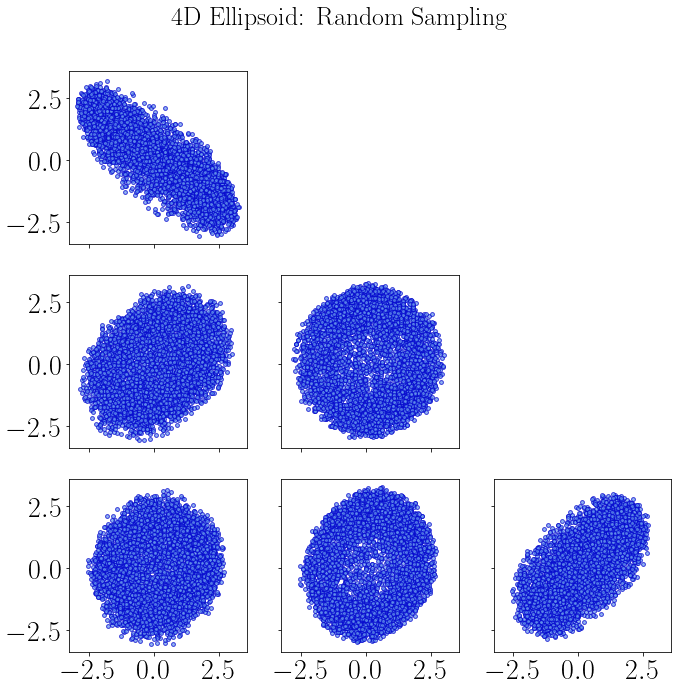

In [186]:
fig, ax = plt.subplots(3,3, figsize=(10,10), sharex=True,sharey=True)

for i in range(4):
    for j in range(4):
        if i > j:
            ax[i-1,j].scatter(ellipsoid_rand_both_4d[:,i], ellipsoid_rand_both_4d[:,j], s=15, c='cornflowerblue', ec='mediumblue', lw=1, alpha=0.7)
            
ax[0,1].axis('off')
ax[0,2].axis('off')
ax[1,2].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle('4D Ellipsoid: Random Sampling', fontsize=26)
fig.tight_layout()

plt.savefig('figures/4D_random_ellipsoid.pdf', bbox_inches='tight', facecolor='white', transparent=False)


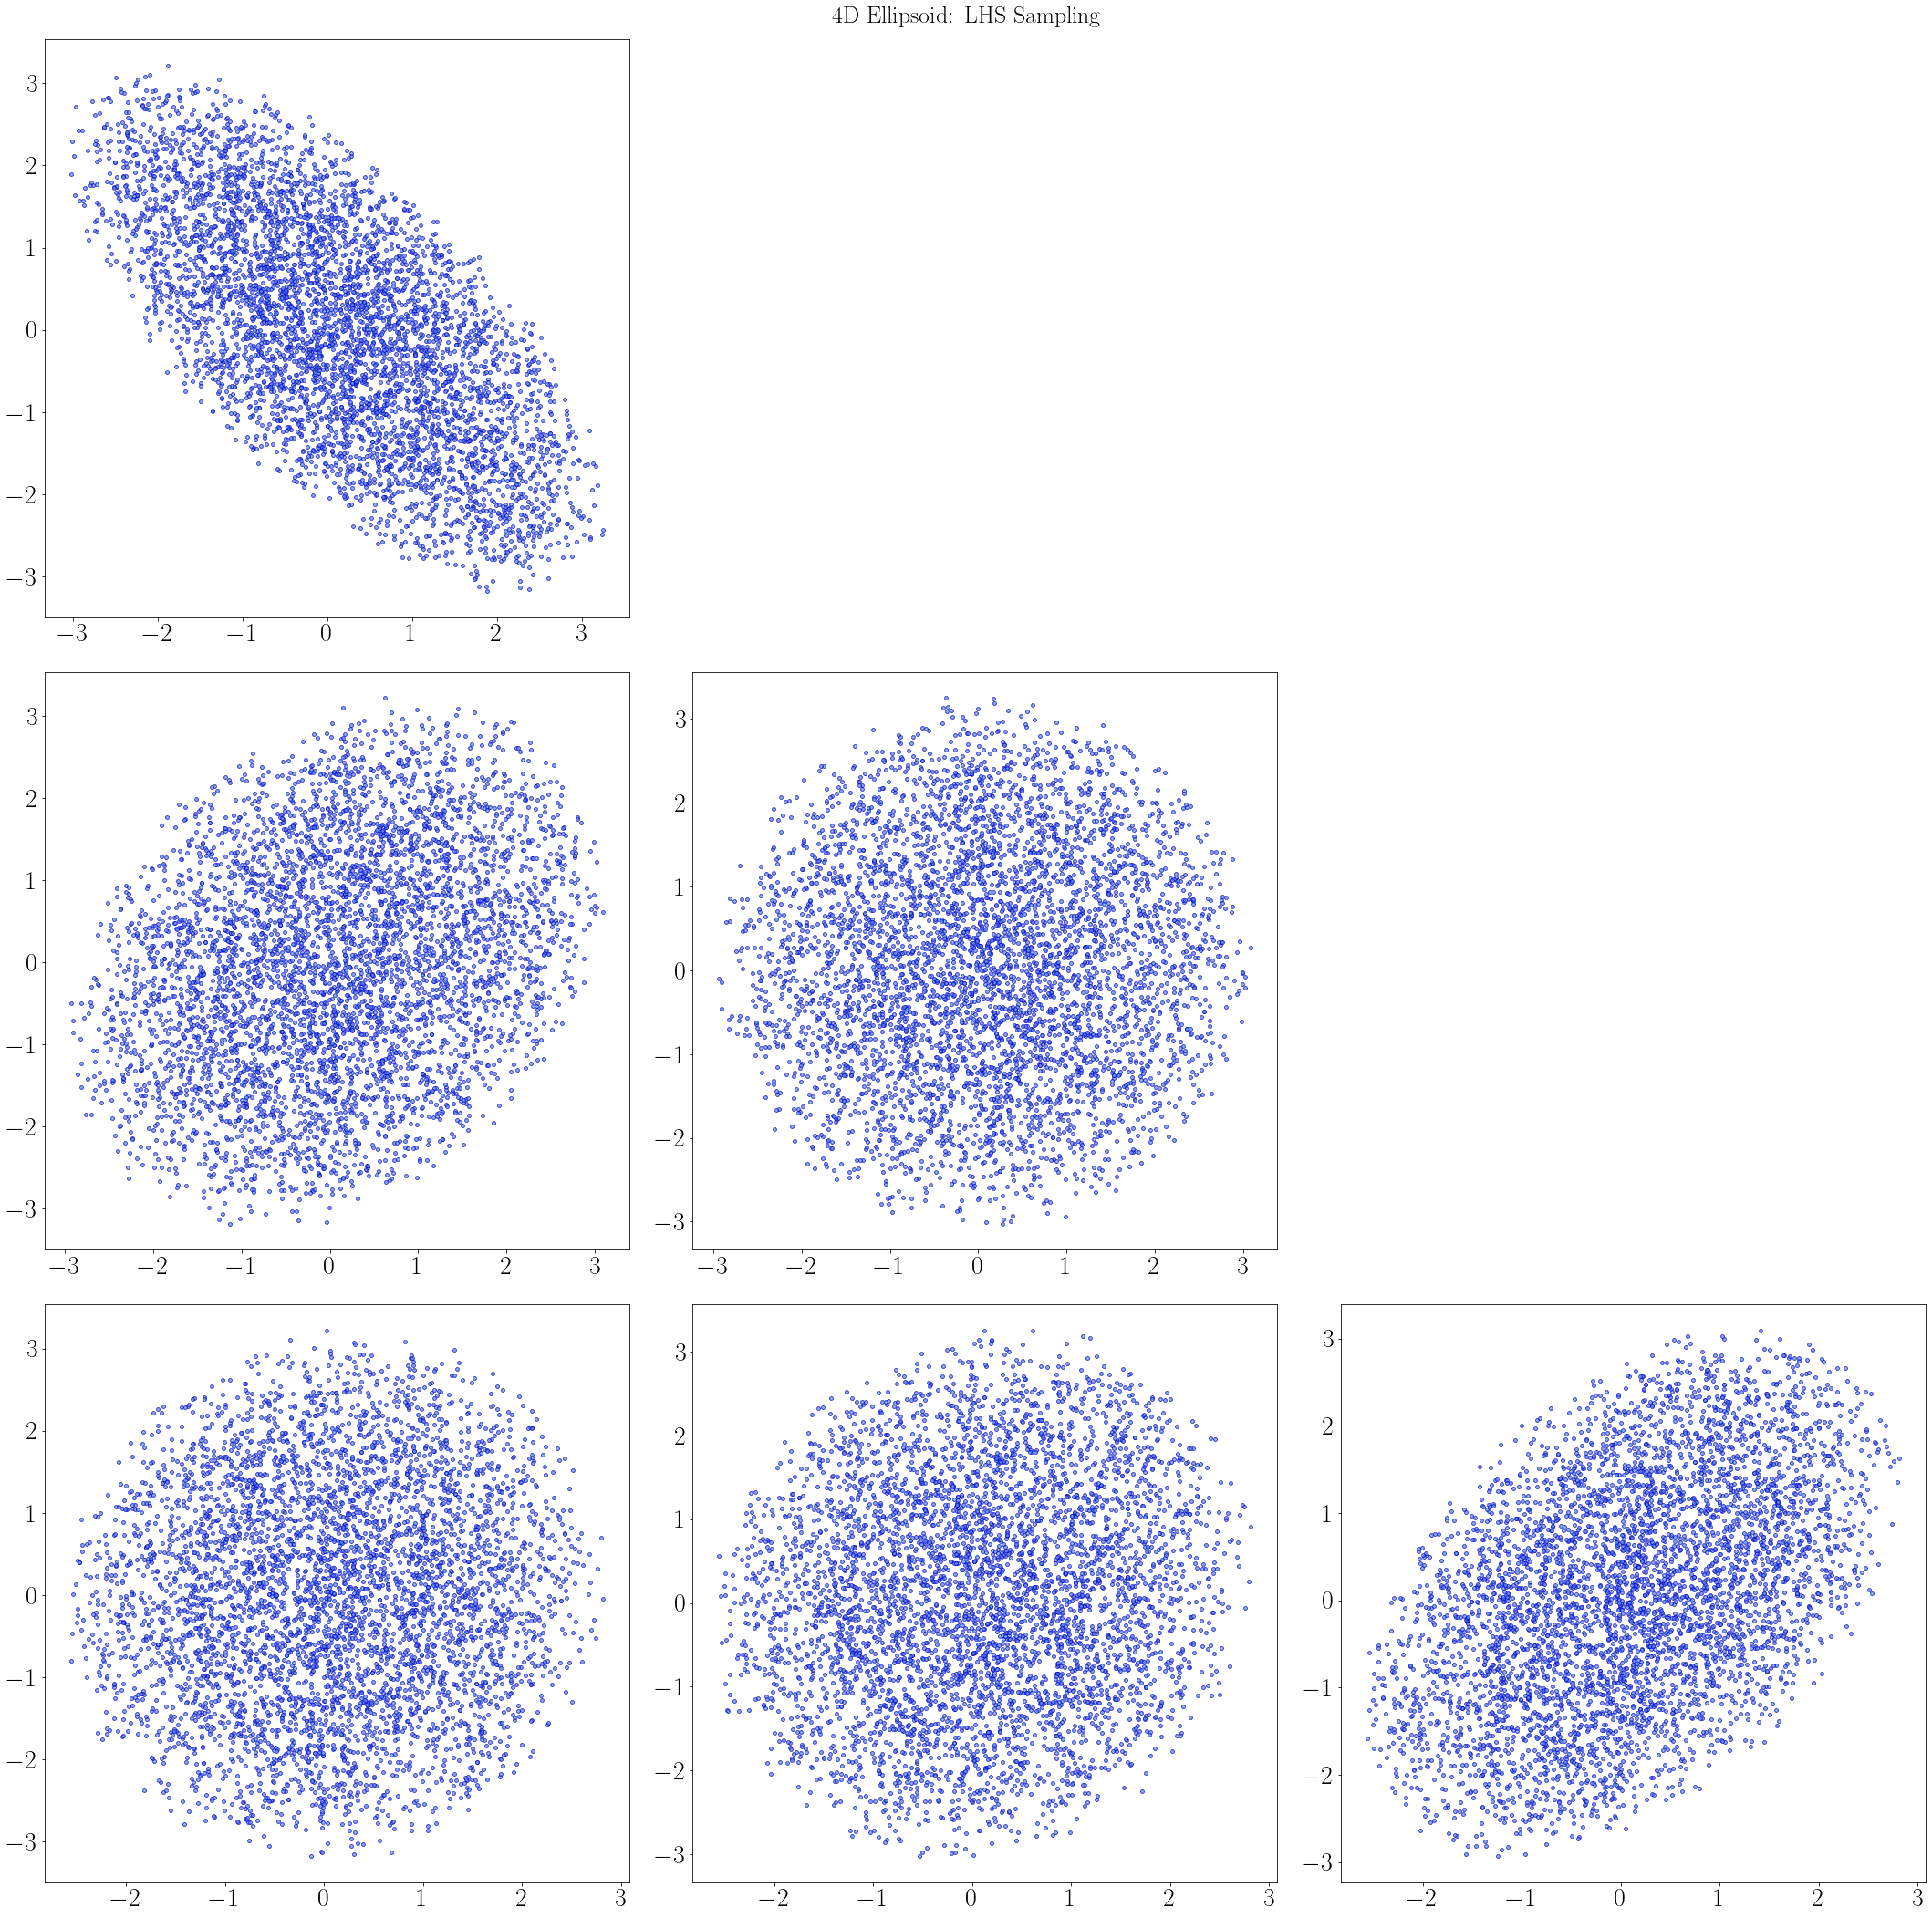

In [187]:
fig, ax = plt.subplots(3,3, figsize=(30,30))

for i in range(4):
    for j in range(4):
        if i > j:
            ax[i-1,j].scatter(ellipsoid_lhs_4d[:,i], ellipsoid_lhs_4d[:,j], s=15, c='cornflowerblue', ec='mediumblue', lw=1, alpha=0.7)
            
            
            ax[0,1].axis('off')
            
ax[0,2].axis('off')
ax[1,2].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle('4D Ellipsoid: LHS Sampling', fontsize=26)
fig.tight_layout()

plt.savefig('figures/4D_lhs_ellipsoid.pdf', bbox_inches='tight', facecolor='white', transparent=False)

In [188]:
def nn(x):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(x)
    distances, indices = nbrs.kneighbors(x)
    return distances

In [189]:
def normal_dist(x,mean,var):
    sigma = np.sqrt(var)
    
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mean)/sigma)**2)

x = np.linspace(-3,10,100)

In [190]:
nbins = 20

ellipsoid_hist_lhs, xhist_lhs, yhist_lhs = np.histogram2d(ellipsoid_lhs_2D[:,0],ellipsoid_lhs_2D[:,1], bins=nbins, density=False)
ellipsoid_hist_rand, xhist_rand, yhist_rand = np.histogram2d(ellipsoid_rand_samples_2D[:,0],ellipsoid_rand_samples_2D[:,1], bins=nbins, density=False)
ellipsoid_hist_rand_both, xhist_rand, yhist_rand_both = np.histogram2d(ellipsoid_rand_both_2D[:,0],ellipsoid_rand_both_2D[:,1], bins=nbins, density=False)

#gaussian_hist_lhs, xhist_lhs, yhist = np.histogram2d(gaussian_lhs[:,0],gaussian_lhs[:,1], bins=10, density=False)
#gaussian_hist_rand, xhist_rand, yhist = np.histogram2d(gaussian_rand[:,0],gaussian_rand[:,1], bins=10, density=False)

combined_data = np.array([ellipsoid_hist_lhs.flatten(),ellipsoid_hist_rand.flatten(), ellipsoid_hist_rand_both.flatten()])
#Get the min and max of all your data
_min, _max = np.amin(combined_data), np.amax(combined_data)

In [191]:
# calculate approximate area of ellipse within grid cells

# find the intersection of the ellipse with the x axis, given the y cell boundaries

def intersect_x(y, covariance):
    
    a = covariance[0,0]
    b = covariance[0,1]
    c = covariance[1,0]
    d = covariance[1,1]
    
    g = 5.991*(d*a - b*c)
    
    x = (np.sqrt( 4*d*(g - a*(y**2)) + (y**2)*(b+c)**2 ) + b*y + c*y ) / 2*d
    
    x2 = (-np.sqrt( 4*d*(g - a*(y**2)) + (y**2)*(b+c)**2 ) + b*y + c*y ) / 2*d
    
    return x, x2



def intersect_y(x, covariance):
    
    a = covariance[0,0]
    b = covariance[0,1]
    c = covariance[1,0]
    d = covariance[1,1]
    
    g = 5.991*(d*a - b*c)
    
    y = (np.sqrt( 4*a*(g - d*(x**2)) + (x**2)*(b+c)**2 ) + b*x + c*x ) / 2*a
    
    y2 = (-np.sqrt( 4*a*(g - d*(x**2)) + (x**2)*(b+c)**2 ) + b*x + c*x ) / 2*a
    
    
    return y, y2

In [192]:
x_intersect, x_intersect_neg = intersect_x(yhist_lhs, np.array([[1,-0.7],[-0.7,1]]))
y_intersect, y_intersect_neg = intersect_x(xhist_lhs, np.array([[1,-0.7],[-0.7,1]]))

/tmp/ipykernel_40457/2302458223.py:14: RuntimeWarning: invalid value encountered in sqrt
  x = (np.sqrt( 4*d*(g - a*(y**2)) + (y**2)*(b+c)**2 ) + b*y + c*y ) / 2*d
/tmp/ipykernel_40457/2302458223.py:16: RuntimeWarning: invalid value encountered in sqrt
  x2 = (-np.sqrt( 4*d*(g - a*(y**2)) + (y**2)*(b+c)**2 ) + b*y + c*y ) / 2*d


In [193]:
def find_edges():
    
    N = len(x_intersect_neg)
    
    # *** top half ****
    # check each x column for an intersect
    edges = np.zeros((len(y_intersect),len(y_intersect)))
    for i in range(len(y_intersect)):
        if np.isnan(y_intersect[i]):
            # no intersect - skip over
            continue
        else:
            # intersect - find corresponding cell
            # intersect falls on x boundary of:
            xval = xhist_lhs[i]
            # i = column number
            # need j = row number
            # we know y intersect so check where it lies
            for j in range(len(yhist_lhs)-1):
                ymin = yhist_lhs[j]
                ymax = yhist_lhs[j+1]
                
                if y_intersect[i] <= ymax and y_intersect[i] >= ymin:
                    #print('coord: ' + str(i) + ',' + str(j))
                    edges[i,j] = 1
                    for k in np.arange(j,N,1):
                        edges[i,k] = 1
                    
                    xmin = xhist_lhs[i]
                    xmax = xhist_lhs[i+1]
                    
                    if x_intersect[j] <= xmax and x_intersect[j] >= xmin:
                        edges[i,j-1] = 1
                        
                        
    # *** top half ****
    # check each x column for an intersect
    for i in range(len(x_intersect)):
        if np.isnan(x_intersect[i]):
            # no intersect - skip over
            continue
        else:
            # intersect - find corresponding cell
            # intersect falls on x boundary of:
            yval = yhist_lhs[i]
            # i = column number
            # need j = row number
            # we know y intersect so check where it lies
            for j in range(len(xhist_lhs)-1):
                xmin = xhist_lhs[j]
                xmax = xhist_lhs[j+1]
                
                if x_intersect[i] <= xmax and x_intersect[i] >= xmin:
                    #print('coord: ' + str(i) + ',' + str(j))
                    edges[j,i] = 1
                    for k in np.arange(j,N,1):
                        edges[k,i] = 1
                    
                    ymin = yhist_lhs[i]
                    ymax = yhist_lhs[i+1]
                    
                    if y_intersect[j] <= ymax and y_intersect[j] >= ymin:
                        edges[j-1,i] = 1
                        
                        
                        
                        
    # *** bottom half ****
    for i in range(len(x_intersect_neg)):
        if np.isnan(x_intersect_neg[i]):
            # no intersect - skip over
            continue
        else:
            # intersect - find corresponding cell
            # intersect falls on x boundary of:
            yval = yhist_lhs[i]
            # i = column number
            # need j = row number
            # we know y intersect so check where it lies
            for j in range(len(xhist_lhs)-1):
                xmin = xhist_lhs[j]
                xmax = xhist_lhs[j+1]
                
                if x_intersect_neg[i] <= xmax and x_intersect_neg[i] >= xmin:
                    #print('coord: ' + str(i) + ',' + str(j))
                    edges[j,i] = 1
                    for k in np.arange(0,j,1):
                        edges[k,i] = 1
                    
                    ymin = yhist_lhs[i]
                    ymax = yhist_lhs[i+1]
                    
                    if y_intersect_neg[j] <= ymax and y_intersect_neg[j] >= ymin:
                        edges[j-1,i] = 1
                        
    for i in range(len(y_intersect_neg)):
        if np.isnan(y_intersect_neg[i]):
            # no intersect - skip over
            continue
        else:
            # intersect - find corresponding cell
            # intersect falls on x boundary of:
            xval = xhist_lhs[i]
            # i = column number
            # need j = row number
            # we know y intersect so check where it lies
            for j in range(len(yhist_lhs)-1):
                ymin = yhist_lhs[j]
                ymax = yhist_lhs[j+1]
                
                if y_intersect_neg[i] <= ymax and y_intersect_neg[i] >= ymin:
                    print('coord: ' + str(i) + ',' + str(j))
                    edges[i,j] = 1
                    for k in np.arange(0,j,1):
                        edges[i,k] = 1
                    edges[i,j-1] = 1
                    #edges[i,j] = 1
                    
                    xmin = xhist_lhs[i]
                    xmax = xhist_lhs[i+1]
                    
                    if x_intersect_neg[j] <= xmax and x_intersect_neg[j] >= xmin:
                        edges[i-1,j] = 1
            
            
                    
    return edges
    





coord: 2,12
coord: 3,10
coord: 4,9
coord: 5,8
coord: 6,6
coord: 7,5
coord: 8,4
coord: 9,4
coord: 10,3
coord: 11,2
coord: 12,2
coord: 13,1
coord: 14,1
coord: 15,0
coord: 16,0
coord: 17,0
coord: 18,1


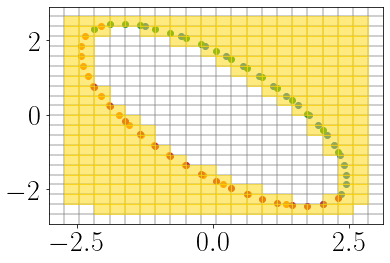

In [194]:

edges = find_edges()

fig, ax = plt.subplots()

ax.scatter(x_intersect, yhist_lhs)
ax.scatter(x_intersect_neg, yhist_lhs)

ax.scatter(xhist_lhs, y_intersect)
ax.scatter(xhist_lhs, y_intersect_neg)

for i in range(len(yhist_lhs)):
    ax.axhline(yhist_lhs[i], alpha=0.5,color='grey',zorder=1)
    ax.axvline(xhist_lhs[i], alpha=0.5,color='grey',zorder=1)
    
for i in range(len(y_intersect)):
    for j in range(len(y_intersect)):
        
        cell = edges[i,j]
        if cell == 1:
            if i < len(y_intersect)-1 and j < len(y_intersect)-1:
                ax.fill_between([xhist_lhs[i],xhist_lhs[i+1]],[yhist_lhs[j]], [yhist_lhs[j+1]], color='gold', alpha=0.5)
            
            #ax.fill_between([xhist_lhs[1],xhist_lhs[1+1]],[yhist_lhs[2]], [yhist_lhs[2+1]], color='blue', alpha=0.05)

In [195]:
# iterate over grid, checking for intersections and calculating fractions
# do only top half, then can mirror?

def fraction_calc(ax, bins):
    
    # counts bins from minimum x and y values to maximum. [-2,-2] is [0,0]
    fractions = np.zeros((bins,bins))
    
    for i in range(bins):
        
        # define x column
        xmin = xhist_lhs[i]
        xmax = xhist_lhs[i+1]
        
        ax.axvline(xmin, alpha=0.5,color='grey')
            
        # find all points falling within x column
        x_intersects = x_intersect[x_intersect < xmax]
        x_intersects = x_intersects[x_intersects > xmin]
        
        y_list = []
        for k in range(len(x_intersects)):
        # find rows the intersects fall in 
            xi = x_intersects[k]
            print('x: ' + str(xi))
            j = np.argwhere(x_intersect == xi)[0][0]
            y_list.append(j)
            
            # find corresponding y row
            ymin = yhist_lhs[j]
            ymax = yhist_lhs[j+1]
            
            # find intersects in this row
            y_intersects = y_intersect[y_intersect < ymax]
            y_intersects = y_intersects[y_intersects > ymin]
            
            # check which intersect falls within cell
            for yval in range(len(y_intersects)):
                m = np.argwhere(y_intersect == y_intersects[yval])[0][0]
                if xhist_lhs[m] <= xmax and xhist_lhs[m] >= xmin:
                    yi = y_intersects[yval]
                    print('y:' + str(yi))
                    #print(bins-j)
                    #print(i)
            
                    # length of sections of cell
                    b = yi - ymin
                    a = xmax - xi

                    # calculate area of segment
                    A = 0.5*b
                    # area of cell
                    A_tot = (ymax-ymin)*(xmax-xmin)
                    fractions[i,bins-j] = A/A_tot
                    
                    ax.scatter(xi,ymin, color='red')
                    ax.scatter(xmin,yi, color='gold')
                    #ax.plot(np.linspace(xi, xmax, 4), np.linspace(yi, ymin, 4))
                    
            ax.axhline(ymin, alpha=0.5,color='grey',zorder=1)
            
            
    return fractions.T
                
            

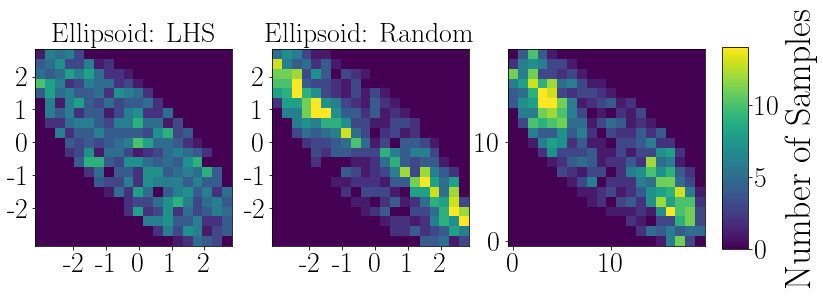

In [196]:
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(12,4))

ax1.imshow(ellipsoid_hist_lhs, vmin = _min, vmax = _max-4, origin='lower')
im2=ax2.imshow(ellipsoid_hist_rand, vmin = _min, vmax = _max-4, origin='lower')
im3=ax3.imshow(ellipsoid_hist_rand_both, vmin = _min, vmax = _max-4, origin='lower')

ax1.set_xticks(np.linspace(3.33, 16.67, 5))
ax1.set_xticklabels([-2,-1,0,1,2])

ax1.set_yticks(np.linspace(3.33, 16.67, 5))
ax1.set_yticklabels([-2,-1,0,1,2])

ax1.set_title('Ellipsoid: LHS')

ax2.set_xticks(np.linspace(3.33, 16.67, 5))
ax2.set_xticklabels([-2,-1,0,1,2])

ax2.set_yticks(np.linspace(3.33, 16.67, 5))
ax2.set_yticklabels([-2,-1,0,1,2])

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(im3, cax=cbar_ax)
cbar_ax.set_ylabel('Number of Samples')

ax2.set_title('Ellipsoid: Random')

#ax2.imshow(ellipsoid_hist_rand)

plt.savefig('figures/ellipsoid_hist.pdf', bbox_inches='tight', facecolor='white', transparent=False)

0.025174825174825177


/tmp/ipykernel_40457/3094102623.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')


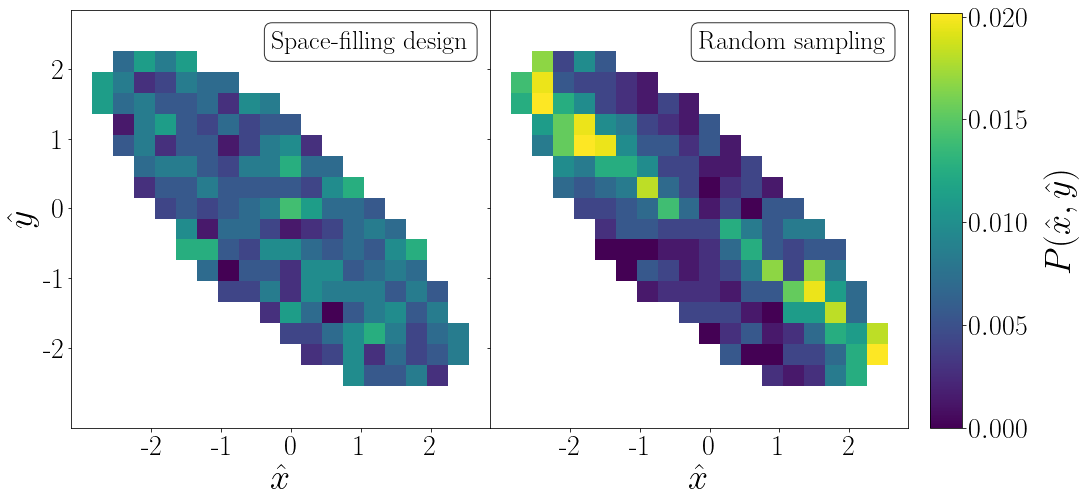

In [204]:
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(15,8),sharex=True,sharey=True)

props = dict(boxstyle='round', facecolor='white', alpha=0.8)

val = 100000
for i in range(nbins):
    for j in range(nbins):
        if edges[i,j] == 1:
            ellipsoid_hist_lhs[i,j] = val
            ellipsoid_hist_rand[i,j] = val
            ellipsoid_hist_rand_both[i,j] = val

ellipsoid_hist_lhs[0:2,0:2] = val
ellipsoid_hist_lhs[nbins-3:nbins,nbins-3:nbins] = val
ellipsoid_hist_lhs[0:2,nbins-3:nbins] = val
ellipsoid_hist_lhs[nbins-3:nbins,0:2] = val

ellipsoid_hist_rand[0:2,0:2] = val
ellipsoid_hist_rand[nbins-3:nbins,nbins-3:nbins] = val
ellipsoid_hist_rand[0:2,nbins-3:nbins] = val
ellipsoid_hist_rand[nbins-3:nbins,0:2] = val

ellipsoid_hist_rand_both[0:2,0:2] = val
ellipsoid_hist_rand_both[nbins-3:nbins,nbins-3:nbins] = val
ellipsoid_hist_rand_both[0:2,nbins-3:nbins] = val
ellipsoid_hist_rand_both[nbins-3:nbins,0:2] = val

masked_array_lhs = np.ma.masked_where(ellipsoid_hist_lhs == val, ellipsoid_hist_lhs)
masked_array_rand = np.ma.masked_where(ellipsoid_hist_rand == val, ellipsoid_hist_rand)
masked_array_rand_both = np.ma.masked_where(ellipsoid_hist_rand_both == val, ellipsoid_hist_rand_both)

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

max_prob = np.max(masked_array_rand/np.sum(masked_array_rand))
print(max_prob)

ax1.imshow(masked_array_lhs/np.sum(masked_array_lhs), cmap=cmap,vmin = 0, vmax = max_prob-0.005, origin='lower')
im2 = ax2.imshow(masked_array_rand/np.sum(masked_array_rand), cmap=cmap,vmin = 0, vmax = max_prob-0.005, origin='lower')
#ax3.imshow(masked_array_rand_both, cmap=cmap,vmin = _min, vmax = _max-4, origin='lower')
#plt.show()


ax1.text(0.48, 0.95, 'Space-filling design', transform=ax1.transAxes, fontsize=26,
        verticalalignment='top', bbox=props)

ax2.text(0.50, 0.95, 'Random sampling', transform=ax2.transAxes, fontsize=26,
        verticalalignment='top', bbox=props)


ax1.set_xticks(np.linspace(3.33, 16.67, 5))
ax1.set_xticklabels([-2,-1,0,1,2])

ax1.set_yticks(np.linspace(3.33, 16.67, 5))
ax1.set_yticklabels([-2,-1,0,1,2])

ax2.set_xticks(np.linspace(3.33, 16.67, 5))
ax2.set_xticklabels([-2,-1,0,1,2])

ax2.set_yticks(np.linspace(3.33, 16.67, 5))
ax2.set_yticklabels([-2,-1,0,1,2])

#ax3.set_xticks(np.linspace(3.33, 16.67, 5))
#ax3.set_xticklabels([-2,-1,0,1,2])

#ax3.set_yticks(np.linspace(3.33, 16.67, 5))
#ax3.set_yticklabels([-2,-1,0,1,2])

ax1.set_ylabel(r'$\hat{y}$')
ax1.set_xlabel(r'$\hat{x}$')
ax2.set_xlabel(r'$\hat{x}$')
#ax3.set_xlabel(r'$\theta_{1}$')

cbar_ax = fig.add_axes([0.92, 0.14, 0.03, 0.72])
fig.colorbar(im2, cax=cbar_ax)
cbar_ax.set_ylabel(r'$P(\hat{x},\hat{y})$', labelpad=15)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('figures/ellipsoid_histogram.pdf', bbox_inches='tight', facecolor='white', transparent=False)
            
            
#ax.imshow(ellipsoid_hist_lhs, vmin = _min, vmax = _max-4, origin='lower')

#ax.axvline(0,1)

#ax.fill_between([-1,3],[nbins-3], [nbins], color='white', alpha=1)

In [31]:
def entropy(hist_array):

    hist_1D = hist_array.flatten()
    N = np.sum(hist_1D)
    probs = np.zeros(len(hist_array))
    
    entropy = 0
    entropy2 = 0
    entropy3 = 0
    
    sumcheck = 0
    
    # iterate over rows
    for i in range(len(hist_array)):
        # in each column, sum occurances
        colsum = np.sum(hist_array[:,i])
        p_i = colsum / N

        if p_i != 0:
            entropy += p_i*np.log2(1/p_i)
      
    for j in range(len(hist_1D)):
        p_j = hist_1D[j] / np.sum(hist_1D)
        if p_j != 0:
            entropy2 += p_j*np.log2(1/p_j)
            
            
    for i in range(len(hist_array)):
        for j in range(len(hist_array)):
        # in each column, sum occurances
            p_i = hist_array[i,j] / N

            if p_i != 0:
                entropy3 += p_i*np.log2(1/p_i)
                
            sumcheck += p_i
            
    return entropy2
    

In [32]:
def entropy_colours(hist_array):

    hist_1D = hist_array.flatten()
    N = int(_max)
    total = np.sum(hist_1D)
    #probs = np.zeros(N)
    
    entropy = 0
    
    # iterate over rows
    for i in range(N+1):
        p_i = len(hist_1D[hist_1D == i]) / total
        
        if p_i != 0:
            entropy += p_i*np.log2(1/p_i)
    print(entropy)
    return entropy
    

In [70]:
entropies_2d_lhs = []
entropies_2d_rand = []

for i in range(5000):

    train, ellipsoid_lhs_2D = uniform_ellipsoid_sample(2, 1000, 10, nonimplausible, inactive=False, parameter_bounds=None)

    train, ellipsoid_rand_samples_2D = random_ellipsoid_sample(2, 1000, 10, nonimplausible, inactive=False, parameter_bounds=None, r_rand = False)

    nbins = 20

    ellipsoid_hist_lhs, xhist_lhs, yhist_lhs = np.histogram2d(ellipsoid_lhs_2D[:,0],ellipsoid_lhs_2D[:,1], bins=nbins, density=False)
    ellipsoid_hist_rand, xhist_rand, yhist_rand = np.histogram2d(ellipsoid_rand_samples_2D[:,0],ellipsoid_rand_samples_2D[:,1], bins=nbins, density=False)
    
    ellipsoid_entropy_lhs = entropy(ellipsoid_hist_lhs)
    ellipsoid_entropy_rand = entropy(ellipsoid_hist_rand)
    
    entropies_2d_lhs.append(ellipsoid_entropy_lhs)
    entropies_2d_rand.append(ellipsoid_entropy_rand)


7.485352214040356


/home/ellie/anaconda3/envs/nn-mwpc-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ellie/anaconda3/envs/nn-mwpc-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


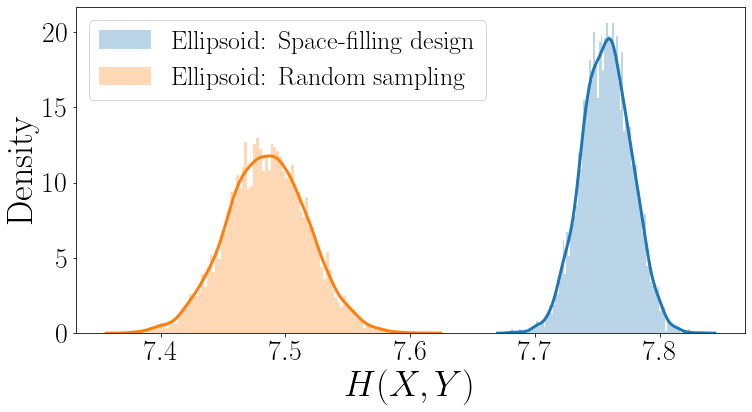

In [209]:
data = np.concatenate([np.array(entropies_2d_lhs).reshape(-1,1), np.array(entropies_2d_rand).reshape(-1,1)], axis=1)    

print(np.mean(entropies_2d_rand))
plt.rcParams["patch.force_edgecolor"] = False

fig, ax = plt.subplots(figsize=(12,6))

sns.distplot(entropies_2d_lhs, kde=True, bins=100, ax=ax, hist_kws={"alpha": 0.3}, kde_kws={"lw": 3}, label='Ellipsoid: Space-filling design')
sns.distplot(entropies_2d_rand, kde=True, bins=100, ax=ax, hist_kws={"alpha": 0.3}, kde_kws={"lw": 3}, label='Ellipsoid: Random sampling')
ax.set_xlabel('$H(X,Y)$')
ax.legend(loc='best')

plt.savefig('figures/sample_entropy.pdf', bbox_inches='tight', facecolor='white', transparent=False)

In [29]:
ellipsoid_entropy_lhs = entropy(ellipsoid_hist_lhs)
ellipsoid_entropy_rand = entropy(ellipsoid_hist_rand)


7.751533991340615
7.751533991340615
7.536919190889402
7.536919190889402


In [ ]:
print(ellipsoid_entropy_lhs)
print(ellipsoid_entropy_rand)
print(ellipsoid_entropy_rand_both)

In [ ]:


print(np.log2(nbins**2))


#print(np.log2(1000))


In [229]:
def entropy_4D(hist_array):

    hist_1D = hist_array.flatten()
    N = np.sum(hist_1D)
    probs = np.zeros(len(hist_array))
    
    entropy = 0
    entropy3 = 0
            
    for i in range(len(hist_array)):
        for j in range(len(hist_array)):
            for k in range(len(hist_array)):
                for l in range(len(hist_array)):
                    # in each column, sum occurances
                    p_i = hist_array[i,j,k,l] / N
                    
                    if p_i != 0:
                        entropy3 += p_i*np.log2(1/p_i)
                    
    
    return entropy3
    

In [230]:
# find points on surface of ellipsoid
covariance4d = np.array([[1,-0.65, 0.3, 0.14],[-0.65,1, 0, 0], [0.3,0, 1, 0.5], [0.14, 0, 0.5, 1]])
covariance3d = np.array([[1,-0.65, 0.3],[-0.65,1, 0], [0.3,0, 1]])

eigvals, eigvecs = np.linalg.eigh(covariance4d)
chisq = chi2.ppf(0.90, 4)
axes = np.sqrt(chisq) * np.sqrt(eigvals)

print(axes)
print(chisq)

# this isnt aligned with the ellipsoid since eigenvalues are ordered

# equation of ellipsoid
def ellipsoid_eqn(pt):
    point = pt.reshape(-1,1)
    #x1,x2,x3,x4 = pt
    #return (x1/axes[0])**2 + (x2/axes[1])**2 + (x3/axes[2])**2 + (x4/axes[3])**2
    
    return np.dot(point.T,np.dot(np.linalg.inv(covariance4d),point))[0][0]

[1.47054225 2.02079819 3.26963898 3.76578045]
7.779440339734858


In [231]:
# construct new array without edge points
ellipsoid_lhs_4d_reduced = []
ellipsoid_rand_both_4d_reduced = []

for i in range(len(ellipsoid_lhs_4d)):
    dist = ellipsoid_eqn(ellipsoid_lhs_4d[i])
    dist2 = ellipsoid_eqn(ellipsoid_rand_both_4d[i])
    
    if dist < chisq:
        ellipsoid_lhs_4d_reduced.append(ellipsoid_lhs_4d[i])
    if dist2 < chisq:
        ellipsoid_rand_both_4d_reduced.append(ellipsoid_rand_both_4d[i])

In [232]:
entropies_4d_lhs = []
entropies_4d_rand = []

for i in range(5000):

    train, ellipsoid_lhs_4d = uniform_ellipsoid_sample(4, 1000000, 10, nonimplausible2, inactive=False, parameter_bounds=None)

    train, ellipsoid_rand_samples_4d = random_ellipsoid_sample(4, 1000000, 10, nonimplausible2, inactive=False, parameter_bounds=None, r_rand = False)

    nbins = 20

    hist_lhs_4d, edges = np.histogramdd(np.asarray(ellipsoid_lhs_4d), bins=nbins)
    hist_rand_4d, edges = np.histogramdd(np.asarray(ellipsoid_rand_samples_4d), bins=nbins)
    
    ellipsoid_entropy_lhs = entropy_4D(hist_lhs_4d)
    ellipsoid_entropy_rand = entropy_4D(hist_rand_4d)
    
    entropies_4d_lhs.append(ellipsoid_entropy_lhs)
    entropies_4d_rand.append(ellipsoid_entropy_rand)

In [233]:
print(np.mean(np.array(entropies_4d_lhs)))
print(np.mean(np.array(entropies_4d_rand)))

15.046913938022586
14.501643351175193


In [227]:
entropy_4D(hist_rand_4d)
entropy_4D(hist_lhs_4d)

14.219063960990892
15.042985846314476


0

In [215]:
print(np.log2(nbins**4))

17.28771237954945
